In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai
from lib.utils_ import powerset
from importlib import reload

In [4]:
from copy import copy, deepcopy

# Load Data

In [5]:
data_dict = {}

## Adult DS

In [6]:
adult_ds = pd.read_csv(DATASETS_DIR+'/adult/adult.data', header=None)
fs = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
      'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week','native-country',
      'y']
adult_ds.columns = fs
adult_ds['y_bin'] = adult_ds['y']==' >50K'
cat_feats = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
y_feat = 'y_bin'
train_feats = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-loss','native-country']
adult_ds.drop(train_feats,1)

print(adult_ds.shape)
adult_ds.head(2)

(32561, 16)


age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   

        marital-status        occupation    relationship    race    sex  \
0        Never-married      Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse   Exec-managerial         Husband   White   Male   

   capital-gain  capital-loss  hours-per-week  native-country       y  y_bin  
0          2174             0              40   United-States   <=50K  False  
1             0             0              13   United-States   <=50K  False

In [7]:
data_dict['adult'] = {'ds':adult_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat,}

# Test

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [9]:
from sklearn.metrics import f1_score, accuracy_score, log_loss

In [10]:
from lib import fca_interp as fcai

In [11]:
from datetime import datetime

In [12]:
data_name = 'adult'
data = data_dict[data_name]
ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']
for f in cat_feats:
    ds[f+'_le'] = LabelEncoder().fit_transform(ds[f])

In [13]:
train_idxs = ds.index[:23000]
test_idxs = ds.index[23000:]

In [14]:
X_train = ds.loc[train_idxs, [f+('_le' if f in cat_feats else '') for f in train_feats] ]
y_train = ds.loc[train_idxs, y_feat]
X_test = ds.loc[test_idxs, [f+('_le' if f in cat_feats else '') for f in train_feats] ]
y_test = ds.loc[test_idxs, y_feat]

In [15]:
stat_ds = []
for model in tqdm([DecisionTreeClassifier(), RandomForestClassifier(),
              GradientBoostingClassifier(), XGBClassifier(), LGBMClassifier()]):
    stat = {'model':model.__class__}
    
    dt1 = datetime.now()
    model.fit(X_train, y_train)
    dt2 = datetime.now()
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    
    
    stat['acc_train'] = accuracy_score(y_train, preds_train)
    stat['acc_test'] = accuracy_score(y_test, preds_test)
    stat['f1_train'] = f1_score(y_train, preds_train)
    stat['f1_test'] = f1_score(y_test, preds_test)
    stat['time'] = (dt2-dt1).total_seconds()
    
    stat_ds.append(pd.Series(stat))

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
mtrx_1 = rf.estimators_[0].decision_path(X_train)

In [17]:
mtrx_2 = rf.estimators_[1].decision_path(X_train)

In [18]:
mtrx_1.shape

(23000, 7571)

In [19]:
mtrx_2.shape

(23000, 7639)

In [20]:
mtrx_1

<23000x7571 sparse matrix of type '<class 'numpy.int64'>'
	with 352747 stored elements in Compressed Sparse Row format>

In [21]:
import scipy as sp

In [22]:
%%timeit
sp.sparse.hstack([mtrx_1, mtrx_2])

21.4 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
mtrx_1_csc = mtrx_1.tocsc()

In [24]:
mtrx_2_csc = mtrx_2.tocsc()

In [25]:
mtrx_1_d = mtrx_1.todense()

In [26]:
mtrx_ds = pd.DataFrame(mtrx_1_d)

In [27]:
%%time
mtrx_1_un = np.unique(mtrx_1_d, axis=1)

CPU times: user 20.2 s, sys: 481 ms, total: 20.7 s
Wall time: 20.7 s


In [28]:
mtrx_1_scs_d = mtrx_1_csc.todense()

In [29]:
%%time
mtrx_1_un = np.unique(mtrx_1_scs_d, axis=1)

CPU times: user 17.3 s, sys: 346 ms, total: 17.7 s
Wall time: 17.6 s


In [30]:
paths_ = rf.estimators_[0].decision_path(X_train)

In [31]:
rf.estimators_[0].tree_.children_left

array([ 1,  2,  3, ..., -1, -1, -1])

In [32]:
rf.estimators_[0].tree_.children_right

array([890, 645, 630, ...,  -1,  -1,  -1])

In [33]:
paths = rf.decision_path(X_train)[0]

In [34]:
paths = paths.tocsc()

In [35]:
m = paths.sum(0)

In [36]:
len(m.tolist()[0])

769036

In [37]:
ser = pd.Series(m.tolist()[0])

In [38]:
def sparse_unique_columns(M):
    M = M.tocsc()
    m, n = M.shape
    if not M.has_sorted_indices:
        M.sort_indices()
    if not M.has_canonical_format:
        M.sum_duplicates()
    sizes = np.diff(M.indptr)
    idx = np.argsort(sizes)
    Ms = M@sp.sparse.csc_matrix((np.ones((n,)), idx, np.arange(n+1)), (n, n))
    ssizes = np.diff(Ms.indptr)
    ssizes[1:] -= ssizes[:-1]
    grpidx, = np.where(ssizes)
    grpidx = np.concatenate([grpidx, [n]])
    if ssizes[0] == 0:
        counts = [np.array([0, grpidx[0]])]
    else:
        counts = [np.zeros((1,), int)]
    ssizes = ssizes[grpidx[:-1]].cumsum()
    for i, ss in enumerate(ssizes):
        gil, gir = grpidx[i:i+2]
        pl, pr = Ms.indptr[[gil, gir]]
        dv = Ms.data[pl:pr].view(f'V{ss*Ms.data.dtype.itemsize}')
        iv = Ms.indices[pl:pr].view(f'V{ss*Ms.indices.dtype.itemsize}')
        idxi = np.lexsort((dv, iv))
        dv = dv[idxi]
        iv = iv[idxi]
        chng, = np.where(np.concatenate(
            [[True], (dv[1:] != dv[:-1]) | (iv[1:] != iv[:-1]), [True]]))
        counts.append(np.diff(chng))
        idx[gil:gir] = idx[gil:gir][idxi]
    counts = np.concatenate(counts)
    nu = counts.size - 1
    uniques = M@sp.sparse.csc_matrix((np.ones((nu,)), idx[counts[:-1].cumsum()],
                                   np.arange(nu + 1)), (n, nu))
    return uniques, idx, counts[1:]

In [39]:
unq, idx, cnt  = sparse_unique_columns(paths)

In [40]:
ser = pd.Series(unq.sum(0).tolist()[0])

In [41]:
idxs = list(ser[(ser>=1000)].index)
len(idxs)

4450

In [42]:
paths_short = unq[:,idxs]

In [43]:
f = lambda i, paths, objs: tuple(objs[(paths[:, i] == 1).todense().flatten().tolist()[0]])

In [44]:
from joblib import Parallel, delayed

In [45]:
n_jobs = -1

In [46]:
%%time
exts = Parallel(n_jobs)([delayed(f)(i, paths_short, X_train.index) for i in range(paths_short.shape[1])])

CPU times: user 1.11 s, sys: 557 ms, total: 1.67 s
Wall time: 15.4 s


In [47]:
from lib import pattern_structure

In [48]:
pattern_structure = reload(pattern_structure)

In [232]:
fcai = reload(fcai)

In [233]:
cntx_train_small = fcai.MultiValuedContext(ds.loc[train_idxs, train_feats].head(100), y_true=y_train[:100], cat_attrs=cat_feats)
cntx_test_small = fcai.MultiValuedContext(ds.loc[test_idxs, train_feats].head(100), cat_attrs=cat_feats)

In [234]:
%%time

cntx_train = fcai.MultiValuedContext(ds.loc[train_idxs, train_feats], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(ds.loc[test_idxs, train_feats], cat_attrs=cat_feats)

#fm = fcai.FormalManager(cntx_train)
#fm.construct_concepts(algo='RandomForest', rf_params={'n_estimators':2, 'max_depth':5}, use_tqdm=True)
#fm.construct_concepts(algo='RandomForest', rf_params={}, use_tqdm=True)

CPU times: user 50.6 ms, sys: 55 µs, total: 50.7 ms
Wall time: 49.6 ms


In [235]:
rf_params = {'n_estimators':100, 'max_depth':None}

In [236]:
fm = fcai.FormalManager(cntx_train_small)
#fm.construct_concepts(algo='RandomForest', rf_params=rf_params)

In [246]:
xaxis = [1,10,100,300,600,1000,3000,10000]
yaxis_old = []
yaxis_new = []
for x in tqdm(xaxis):
    cntx_train_small = fcai.MultiValuedContext(
        ds.loc[train_idxs, train_feats].head(x),
        y_true=y_train[:x], cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train_small)
    
    t1 = datetime.now()
    concepts_ = fm._random_forest_concepts_old(rf_params=rf_params)
    t2 = datetime.now()
    yaxis_old.append((t2-t1).total_seconds())
    
    t1 = datetime.now()
    concepts_ = fm._random_forest_concepts(rf_params=rf_params)
    t2 = datetime.now()
    yaxis_new.append((t2-t1).total_seconds())

/root/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



KeyboardInterrupt: 

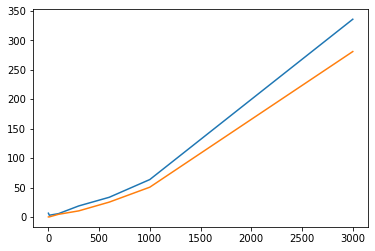

In [250]:
plt.plot(xaxis[:-1], yaxis_old)
plt.plot(xaxis[:-1], yaxis_new)

In [237]:
%%time
concepts_ = fm._random_forest_concepts_old(rf_params=rf_params);

CPU times: user 1.88 s, sys: 20.1 ms, total: 1.9 s
Wall time: 6.42 s


In [238]:
%%time
concepts_ = fm._random_forest_concepts(rf_params=rf_params);

CPU times: user 1.66 s, sys: 16.3 ms, total: 1.68 s
Wall time: 2.24 s


In [142]:
fm._concepts = concepts

In [143]:
for idx, c in enumerate(fm.sort_concepts()):
    c._idx = idx

In [144]:
%%time
fm._construct_spanning_tree()


CPU times: user 16.9 s, sys: 157 ms, total: 17 s
Wall time: 16.9 s


In [145]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = y_train[[int(g) for g in c.get_extent()]].mean()

In [146]:
%%time
preds1 = fm.predict_context(cntx_test_small)

CPU times: user 15.4 s, sys: 19.2 ms, total: 15.4 s
Wall time: 15.4 s


In [ ]:
from sklearn.ensemble import 

In [61]:
import sklearn.ensemble

In [63]:
sklearn.ensemble

<module 'sklearn.ensemble' from '/root/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/__init__.py'>

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
isinstance(rf, (RandomForestClassifier, RandomForestRegressor))

True

In [150]:
paths = rf.decision_path(X_train)[0].tocsc()

In [158]:
nz = paths.nonzero()

In [159]:
len(nz)

2

In [160]:
paths

<23000x769036 sparse matrix of type '<class 'numpy.longlong'>'
	with 37796421 stored elements in Compressed Sparse Column format>

In [180]:
%%timeit
cntx_train.get_objs()[paths[:,1].indices]

209 µs ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [183]:
f = lambda i, paths: tuple(cntx_train.get_objs()[(paths[:, i] == 1).todense().flatten().tolist()[0]])

In [187]:
%%timeit
f(1, paths)

3.49 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [194]:
paths[:,1].indices

array([    4,    12,    16, ..., 22996, 22997, 22999], dtype=int32)

In [198]:
%%timeit
paths.nonzero()

4.32 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [199]:
paths_csr = paths.tocsr()

In [200]:
%%timeit
paths_csr.nonzero()

446 ms ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [216]:
%%timeit
paths.indices[paths.indptr[i]:paths.indptr[i+1]]

686 ns ± 16.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [218]:
%%timeit
tuple(paths.indices[paths.indptr[i]:paths.indptr[i+1]])

544 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [217]:
paths.indices

array([    0,     1,     2, ..., 17734, 19749, 21652], dtype=int32)

In [215]:
%%timeit
cntx_train.get_objs()[paths.indices[paths.indptr[i]:paths.indptr[i+1]]]

47 µs ± 762 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [214]:
%%timeit
tuple(cntx_train.get_objs()[paths.indices[paths.indptr[i]:paths.indptr[i+1]]])

1.52 ms ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [213]:
(3.49*1e-3)/(683*1e-9)

5109.809663250367

In [220]:
%%timeit
(paths[:, i] == 1).todense().flatten().tolist()[0]

629 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
p

In [209]:
i = 1
len(paths.indices[paths.indptr[i]:paths.indptr[i+1]])

6849

In [210]:
paths.indices[paths.indptr[i]:paths.indptr[i+1]]

array([    4,    12,    16, ..., 22996, 22997, 22999], dtype=int32)

In [202]:
paths.indptr

array([       0,    23000,    29849, ..., 37796410, 37796417, 37796421],
      dtype=int32)

In [173]:
len(paths[:,1].nonzero()[0])

6849

In [164]:
len(paths[:,0].indices)

23000

In [161]:
nz

(array([    0,     0,     0, ..., 22999, 22999, 22999], dtype=int32),
 array([     0,    890,   2190, ..., 766864, 766876, 766877], dtype=int32))

In [154]:
paths[:,

<23000x1 sparse matrix of type '<class 'numpy.int64'>'
	with 23000 stored elements in Compressed Sparse Column format>

In [664]:
f = lambda ext: fcai.PatternStructure(ext, cntx_train.get_intent(ext))

In [571]:
concepts = fm.sort_concepts([fcai.PatternStructure(c.get_extent(), c.get_intent()) for c in concepts_base])
for idx, c in enumerate(fm.sort_concepts(concepts)):
    c._idx = idx

In [604]:
fm._concepts = concepts[:1000]#[:1000]#[:500]

In [605]:
len(fm.get_concepts())

1000

In [606]:
fm._construct_spanning_tree()

In [610]:
c._up_neighbs

In [623]:
for c in fm.get_concepts():
    c._low_neighbs = c._low_neighbs_st
    c._up_neighbs = set([c._up_neighb_st]) if c._up_neighb_st is not None else None

In [635]:
for c in fm.get_concepts():
    c._extent = fm.get_context().get_objs()[c._extent]

In [654]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = y_train.loc[[int(g) for g in c.get_extent()]].mean()

In [636]:
fm._calc_concept_levels()

In [638]:
fm._find_new_concept_objatr()

In [655]:
fig = fm.get_plotly_fig(color_by='mean_y_true')

In [658]:
rf.decision_path

<bound method BaseForest.decision_path of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [656]:
fig

In [574]:
fm.get_concept_by_id(40)._up_neighbs

In [577]:
xaxis = np.array([1,10,30,100,300,600,1000])#,3000]
yaxis_old = []
yaxis_new = []
for x in tqdm(xaxis):
    fm._concepts = [fcai.PatternStructure(c.get_extent(), c.get_intent(), idx) for idx, c in enumerate(concepts[:x])]
    t1 = datetime.now()
    fm._construct_spanning_tree()
    t2 = datetime.now()
    yaxis_new.append((t2-t1).total_seconds())
    
    t1 = datetime.now()
    fm._construct_spanning_tree_old()
    t2 = datetime.now()
    yaxis_old.append((t2-t1).total_seconds())

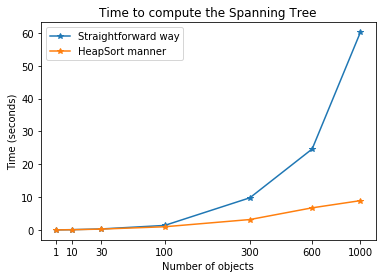

xaxis [   1   10   30  100  300  600 1000]
yaxis_old [0.031733, 0.110667, 0.325264, 1.391511, 9.799253, 24.652681, 60.184621]
yaxis_new [0.02645, 0.085939, 0.278405, 0.986002, 3.183306, 6.747965, 8.936661]


In [603]:
plt.plot(np.log1p(xaxis/50), yaxis_old, '*-', label='Straightforward way')
plt.plot(np.log1p(xaxis/50), yaxis_new, '*-', label='HeapSort manner')
plt.xticks(np.log1p(xaxis/50), xaxis)
plt.legend()
plt.ylabel('Time (seconds)')
plt.xlabel('Number of objects')
plt.title('Time to compute the Spanning Tree')
plt.show()

print('xaxis', xaxis)
print('yaxis_old', yaxis_old)
print('yaxis_new', yaxis_new)

In [562]:
%%time
fm._construct_spanning_tree()


CPU times: user 36.5 s, sys: 256 ms, total: 36.7 s
Wall time: 36.4 s


In [563]:
%%time
fm._construct_spanning_tree_old()

KeyboardInterrupt: 

In [520]:
%%time
fm._construct_spanning_tree()


CPU times: user 1.53 s, sys: 28 ms, total: 1.56 s
Wall time: 1.56 s


In [321]:
%%time
fm._construct_lattice_connections()


CPU times: user 1min 43s, sys: 355 ms, total: 1min 43s
Wall time: 1min 43s


In [385]:
fm.get_concept_by_id(100)._low_neighbs

In [386]:
fm.get_concept_by_id(100)._up_neighb_st

86

In [465]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = ds.loc[[int(g) for g in c.get_extent()], y_feat ].mean()

In [466]:
len(X_train), len(X_test)

(23000, 9561)

In [467]:
fm.get_concept_by_id(10)._metrics

{'mean_y_true': 0.1590541165587419}

In [468]:
preds_train_fm = fm.predict_context(cntx_train, )

In [474]:
%%timeit
preds_train_fm = fm.predict_context(cntx_train)

1.51 s ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [475]:
%%timeit
preds_test_fm = fm.predict_context(cntx_test)

800 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [476]:
%%timeit
preds_train_rf = rf.predict_proba(X_train)

496 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [477]:
%%timeit
preds_test_rf = rf.predict_proba(X_test)

216 ms ± 2.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [480]:
roc_auc_score(y_train, preds_train_fm), roc_auc_score(y_test, preds_test_fm)

(0.6841536742732579, 0.858339613334128)

In [481]:
roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

(0.9999993701705091, 0.8740482824678789)

In [293]:
%%timeit
preds_train_fm = fm.predict_context(cntx_train)

12.1 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [294]:
%%timeit
preds_test_fm = fm.predict_context(cntx_test)

6.4 s ± 64.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [295]:
%%timeit
preds_test_rf = rf.predict_proba(X_test)

215 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [296]:
%%timeit
preds_train_rf = rf.predict_proba(X_train)

443 ms ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%%timeit
preds_train_fm = fm.predict_context(cntx_train)

23.5 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
%%timeit
preds_test_fm = fm.predict_context(cntx_test)

10.3 s ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [106]:
%%timeit
preds_test_rf = rf.predict_proba(X_test)

196 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%%timeit
preds_train_rf = rf.predict_proba(X_train)

432 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
len(preds_test_fm)

9561

In [88]:
from sklearn.metrics import roc_auc_score

In [92]:
roc_auc_score(y_train, preds_train_fm), roc_auc_score(y_test, preds_test_fm)

(0.8548532120429563, 0.858339613334128)

In [99]:
roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

(0.9999993701705091, 0.8740482824678789)

In [60]:
cntx_train_small = fcai.MultiValuedContext(ds.loc[train_idxs, train_feats].head(100), y_true=y_train[:100], cat_attrs=cat_feats)cntx_test_small = fcai.MultiValuedContext(ds.loc[test_idxs, train_feats].head(100), cat_attrs=cat_feats)

In [215]:
len(fm.get_concepts())

445

In [201]:
len(fm.get_concepts())

80

In [187]:
concepts

[PatternStructure
 
 extent (len: 10014): 2, 6, 13, 16, 17, 21, 24, 26, 28, 30, 31, 33, 35, 36, 43, 44, 49, 51, 54, 61, 64, 66, 69, 70, 73, 74, 75, 78, 80, 84, 85, 88, 91, 92, 95, 98, 99, 103, 104, 106, 107, 108, 114, 119, 120, 124, 126, 129, 130, 131, 134, 138, 141, 142, 143, 144, 145, 147, 149, 150, 151, 153, 154, 157, 158, 160, 161, 163, 165, 166, 168, 169, 170, 175, 176, 177, 178, 181, 182, 190, 195, 196, 199, 201, 203, 204, 205, 207, 209, 212, 216, 219, 221, 222, 224, 225, 226, 228, 229, 230, 231, 232, 233, 236, 239, 243, 244, 247, 252, 253, 254, 256, 257, 258, 259, 262, 266, 271, 274, 277, 278, 282, 284, 287, 291, 293, 298, 299, 301, 305, 306, 307, 312, 314, 315, 317, 318, 319, 322, 323, 326, 329, 330, 332, 335, 336, 338, 340, 343, 344, 347, 348, 356, 364, 367, 369, 370, 371, 374, 375, 377, 380, 381, 383, 385, 386, 388, 389, 392, 394, 396, 397, 400, 401, 403, 410, 411, 412, 415, 417, 418, 419, 421, 423, 424, 427, 430, 431, 434, 436, 437, 441, 442, 444, 445, 446, 449, 450, 460, 46

In [186]:
len(concepts)

80

In [172]:
from joblib import Parallel, delayed

In [174]:
tree = rf.estimators_[0]

In [177]:
paths = tree.decision_path(X_train)
#exts = [list(objs[(paths[:, i] == 1).todense().flatten().tolist()[0]]) for i in range(paths.shape[1])]

In [230]:
objs = X_train.index

In [238]:
%%timeit
list(objs[(paths[:, 0] == 1).todense().flatten().tolist()[0]])

6.49 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [232]:
paths_dense = paths.todense()

In [247]:
%%timeit
list(objs[(paths_dense[:, 0] == 1).flatten().tolist()[0]])

5.09 ms ± 624 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [241]:
paths_csc = paths.tocsc()

In [249]:
%%timeit
list(objs[(paths_csc[:, 0] == 1).todense().flatten().tolist()[0]])

5.05 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [243]:
paths_csc_dense = paths_csc.todense()

In [248]:
%%timeit
list(objs[(paths_csc_dense[:, 0] == 1).flatten().tolist()[0]])

4.33 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
RandomForestClassifier(n_jobs=-1)

In [291]:
f = lambda i, paths: list(objs[(paths[:, i] == 1).todense().flatten().tolist()[0]])

In [289]:
from datetime import datetime

In [290]:
paths_csc

<23000x7695 sparse matrix of type '<class 'numpy.longlong'>'
	with 370789 stored elements in Compressed Sparse Column format>

In [295]:
xaxis = [1, 10, 100, 1000, 3000, 7695]
yaxis_before = []
yaxis_par = []
yaxis_ = []
for n in tqdm(xaxis):
    dt1 = datetime.now()
    [f(i, paths) for i in range(n)]
    dt2 = datetime.now()
    yaxis_before.append((dt2-dt1).total_seconds())
    
    dt1 = datetime.now()
    [f(i, paths_csc) for i in range(n)]
    dt2 = datetime.now()
    yaxis_.append((dt2-dt1).total_seconds())
    
    dt1 = datetime.now()
    Parallel(-1)([delayed(f)(i, paths_csc) for i in range(n)])
    dt2 = datetime.now()
    yaxis_par.append((dt2-dt1).total_seconds())

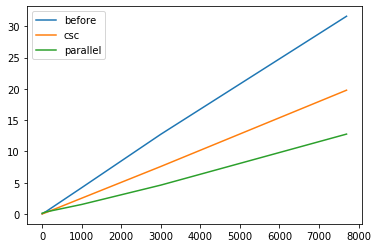

In [297]:
plt.plot(xaxis, yaxis_before, label='before')
plt.plot(xaxis, yaxis_, label='csc')
plt.plot(xaxis, yaxis_par, label='parallel')
plt.legend()
plt.show()

In [301]:
np.array(yaxis_before)/np.array(yaxis_par)

array([0.09620932, 0.66160079, 1.18700697, 2.76229871, 2.7610525 ,
       2.47530616])

In [299]:
yaxis_before[-1]/yaxis_par[-1]

2.475306157131815

In [298]:
yaxis_[-1]/yaxis_par[-1]

1.5495175337953462

In [171]:
mtrx.T.todense().shape

(7695, 23000)

In [35]:
fcai = reload(fcai)

In [42]:
fm.construct_lattice(True)

In [43]:
for c in fm.get_concepts():
    c._metrics['mean_y_true'] = y_train.loc[[int(x) for x in c.get_extent()]].mean()

In [44]:
preds_fm = fm.predict_context(cntx_test,)

In [50]:
preds_fm = np.array(preds_fm)

In [52]:
accuracy_score(y_test, preds_fm>=0.5), f1_score(y_test, preds_fm>=0.5), log_loss(y_test, preds_fm)

(0.815814245371823, 0.5093340763443857, 0.41530440477265046)

In [126]:
accuracy_score(y_test, preds), f1_score(y_test, preds), log_loss(y_test, model.predict_proba(X_test))

(0.8467733500679845, 0.6566674478556362, 0.3348993864031587)